# RAI/USD vs ETH/USD, WIP

Compare RAI/USD and ETH/USD

In [1]:
import os
import time
from decimal import Decimal
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from web3 import Web3, HTTPProvider

from abis import LINK_ETH, LINK_ETH_ABI, LINK_ETH_FIRST_BLOCK
from abis import LINK_RAI, LINK_RAI_ABI, LINK_RAI_FIRST_BLOCK
from abis import ORACLE_RELAYER, ORACLE_RELAYER_ABI, ORACLE_RELAYER_FIRST_BLOCK

from mp import fetch, fetch_link_mp, fetch_rp

size = 15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,12),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}

plt.rcParams.update(params)

In [2]:
# Need an archive node

#ETH_RPC_URL=os.environ['ETH_RPC_URL']
ETH_RPC_URL='https://eth-mainnet.g.alchemy.com/v2/fnqkEt7-LptDIrq8uGem99usR6vUGqq7'

web3 = Web3(HTTPProvider(endpoint_uri=ETH_RPC_URL, request_kwargs={"timeout": 10}))

In [177]:
first_block = max(LINK_ETH_FIRST_BLOCK, ORACLE_RELAYER_FIRST_BLOCK)
interval = 6600 * 1
#interval = 275 # 1 hour
num_blocks = None

latest_block = web3.eth.getBlock("latest")['number']

if not num_blocks:
    last_block = latest_block - 12
else:
    last_block = min(latest_block - 12, first_block + num_blocks)

print(f"first block {first_block}, last_block {last_block}")
blocks = list(range(first_block, last_block + 1, interval))

first block 12000000, last_block 15144631


In [178]:
start = time.time()
rp_results = fetch(fetch_rp, 32, ORACLE_RELAYER, ORACLE_RELAYER_ABI, ETH_RPC_URL, blocks=blocks)
print(f"took {time.time() - start}")

took 10.569822072982788


In [179]:
"""
start = time.time()
rai_results = fetch(fetch_link_mp, 8, LINK_RAI, LINK_RAI_ABI, ETH_RPC_URL, blocks=blocks)
print(f"took {time.time() - start}")
"""

'\nstart = time.time()\nrai_results = fetch(fetch_link_mp, 8, LINK_RAI, LINK_RAI_ABI, ETH_RPC_URL, blocks=blocks)\nprint(f"took {time.time() - start}")\n'

In [180]:
len(rp_results)

477

In [181]:
start = time.time()
eth_results = fetch(fetch_link_mp, 32, LINK_ETH, LINK_ETH_ABI, ETH_RPC_URL, blocks=blocks)
print(f"took {time.time() - start}")

took 10.318294048309326


In [182]:
rai_df = pd.DataFrame(rp_results, columns = ['block', 'price'])
eth_df = pd.DataFrame(eth_results, columns = ['block', 'price', 'ts', 'started_at'])

In [183]:
rai_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 477 entries, 0 to 476
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   block   477 non-null    int64 
 1   price   477 non-null    object
dtypes: int64(1), object(1)
memory usage: 7.6+ KB


In [184]:
rai_df.to_csv('redemption_price_1d_blocks.csv.gz')

In [185]:
eth_df.to_csv('eth_usd_1d_blocks.csv.gz')

Read existing csvs

In [204]:
rai_df = pd.read_csv('redemption_price_1d_blocks.csv.gz')

In [205]:
eth_df = pd.read_csv('eth_usd_1d_blocks.csv.gz')

In [206]:
rai_df.head(4)

,Unnamed: 0,block,price
0,0,12000000,3022808657486628987514678542
1,1,12006600,3017672223523382869905417812
2,2,12013200,3016353519730939642011541465
3,3,12019800,3018491693427242656948331681


In [207]:
rai_df['price'] = rai_df['price'].astype(float)
eth_df['price'] = eth_df['price'].astype(float)

In [208]:
rai_df['rai_ret'] = rai_df['price'].pct_change(7)
eth_df['eth_ret'] = eth_df['price'].pct_change(7)

In [209]:
df = rai_df.merge(eth_df, on='block')

In [210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 477 entries, 0 to 476
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0_x  477 non-null    int64  
 1   block         477 non-null    int64  
 2   price_x       477 non-null    float64
 3   rai_ret       470 non-null    float64
 4   Unnamed: 0_y  477 non-null    int64  
 5   price_y       477 non-null    float64
 6   ts            477 non-null    int64  
 7   started_at    477 non-null    int64  
 8   eth_ret       470 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 37.3 KB


In [211]:
df_final = df[['block', 'rai_ret', 'eth_ret']]

In [212]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 477 entries, 0 to 476
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   block    477 non-null    int64  
 1   rai_ret  470 non-null    float64
 2   eth_ret  470 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 14.9 KB


In [213]:
df_final_index = df_final.set_index('block')

<AxesSubplot:title={'center':'Rolling correlation between 7d ETH/USD returns and 7d Redemption Price returns\nEvery day new 7d returns are calculated and correlation is calculated over the previous 100 samples'}, xlabel='block'>

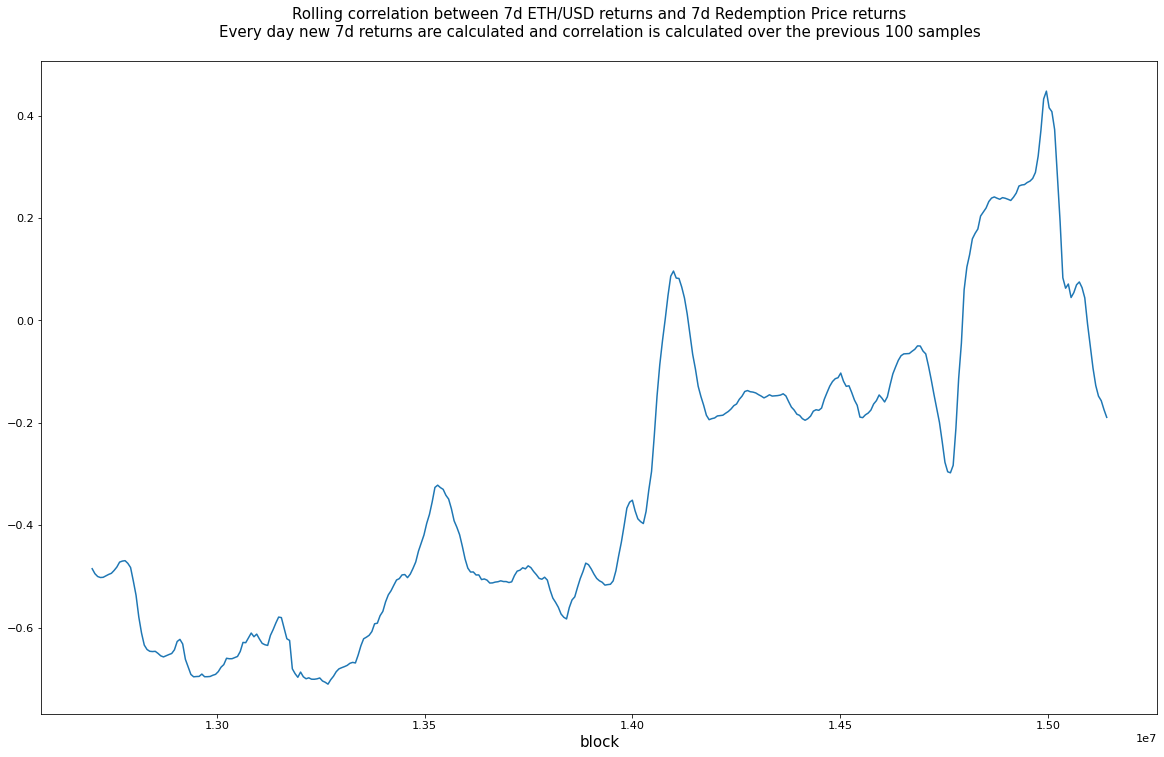

In [224]:
df_final_index['rai_ret'].rolling(100).corr(df_final_index['eth_ret'])\
                         .plot(title='Rolling correlation between 7d ETH/USD returns and 7d Redemption Price returns\nEvery day new 7d returns are calculated and correlation is calculated over the previous 100 samples')



In [215]:
rai_df['price_norm'] = (rai_df['price'] - min(rai_df['price'])) / (max(rai_df['price']) - min(rai_df['price']))
eth_df['price_norm'] = (eth_df['price'] - min(eth_df['price'])) / (max(eth_df['price']) - min(eth_df['price']))

<AxesSubplot:xlabel='block'>

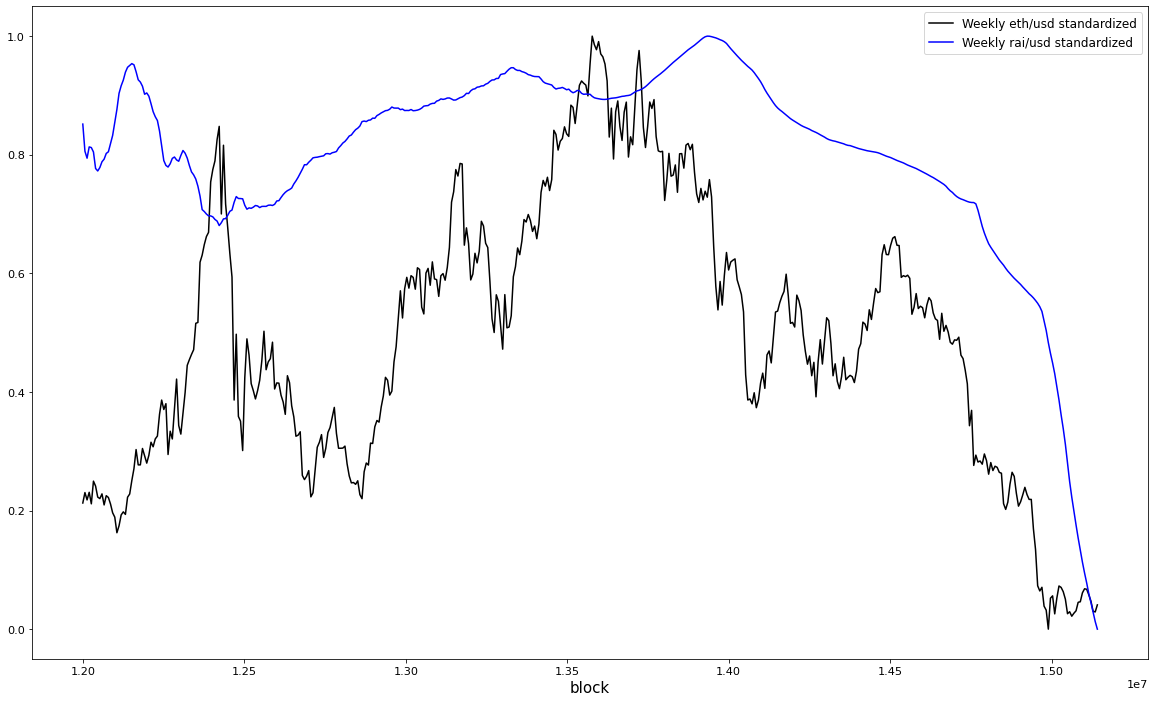

In [216]:
fig, ax = plt.subplots(1,1)
eth_df.plot(y='price_norm', x='block', ax=ax, label='Weekly eth/usd standardized', color='black')
rai_df.plot(y='price_norm', x='block', ax=ax, label='Weekly rai/usd standardized', color='blue')

<AxesSubplot:xlabel='block'>

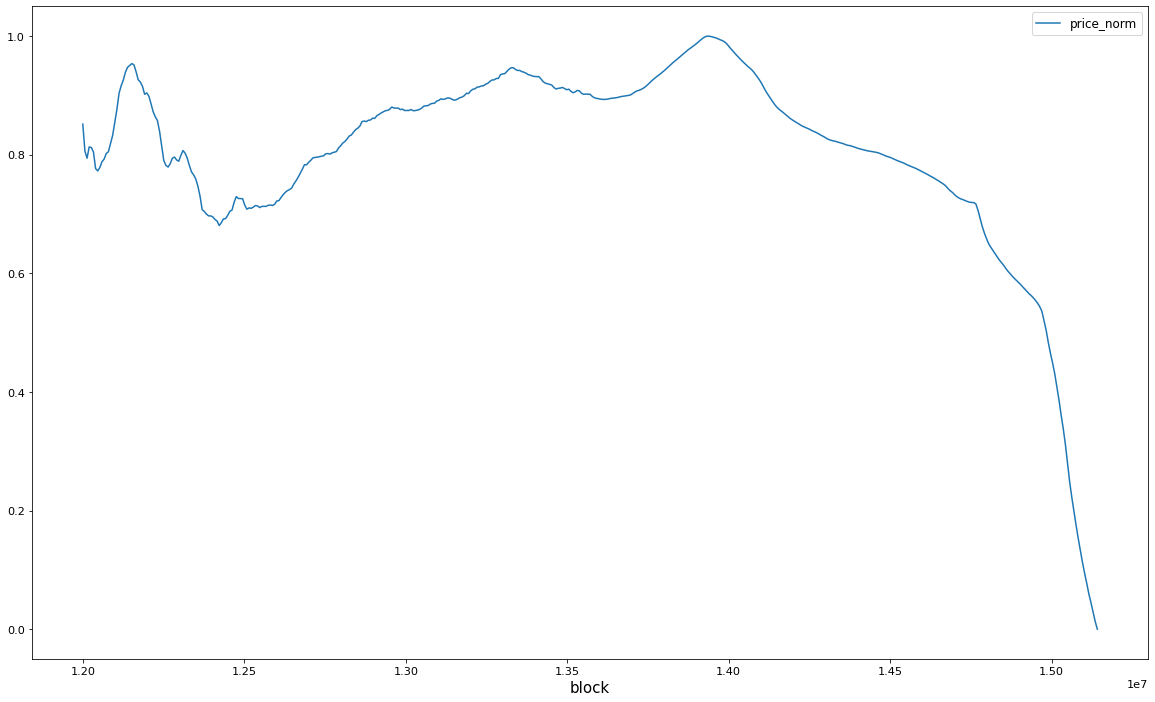

In [217]:
rai_df.plot(y='price_norm', x='block')

In [218]:
'''
# https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas

lagged_correlation = pd.DataFrame.from_dict(
    {x: [df[target].corr(df[x].shift(-t)) for t in range(max_lag)] for x in df.columns})
'''

'\n# https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas\n\nlagged_correlation = pd.DataFrame.from_dict(\n    {x: [df[target].corr(df[x].shift(-t)) for t in range(max_lag)] for x in df.columns})\n'

In [219]:
df_final_index['rai_ret'].astype(float).corr(df_final_index['eth_ret'].shift(1))

-0.10873377846292363

In [220]:
'''
# https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas

lagged_correlation = pd.DataFrame.from_dict(
    {x: [df[target].corr(df[x].shift(-t)) for t in range(max_lag)] for x in df.columns})
'''

'\n# https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas\n\nlagged_correlation = pd.DataFrame.from_dict(\n    {x: [df[target].corr(df[x].shift(-t)) for t in range(max_lag)] for x in df.columns})\n'

In [221]:
max_lag = 168
for x in range(max_lag):
    corr = df_final_index['rai_ret'].iloc[-24*30:].astype(float).corr(df_final_index['eth_ret'].iloc[-24*30:].shift(x))
    print(x, corr)


0 -0.10225424221336582
1 -0.10873377846292363
2 -0.0918605522838653
3 -0.06988197691737262
4 -0.036634655599066944
5 0.006250721130275682
6 0.05274024119201247
7 0.0967601335320872
8 0.14051008980095533
9 0.1692718151346234
10 0.19460927536349748
11 0.21031543106020442
12 0.21701654999185852
13 0.2245306115677343
14 0.23502670280610716
15 0.23707980091010172
16 0.24146557653796577
17 0.2523643024803594
18 0.25926093879024315
19 0.2658481870219301
20 0.26028302968615635
21 0.253655233874273
22 0.2471553580091962
23 0.2307240147964763
24 0.20873630786279024
25 0.18305852932026534
26 0.15434093763842466
27 0.12961933061507735
28 0.10571578395612298
29 0.08780879462582629
30 0.08231133463313473
31 0.08386138397004099
32 0.09616119255879696
33 0.11341130961930643
34 0.13659889995343572
35 0.16193175207425664
36 0.18919402870318577
37 0.21508602751399375
38 0.24015910215330183
39 0.25808705440443364
40 0.27666641265969005
41 0.292733938887058
42 0.3090891865621927
43 0.3205902324239075
44 0.